<a href="https://colab.research.google.com/github/duybluemind1988/Data-science/blob/master/Pytorch/Time_series_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series prediction with Pytorch (many to one)

In [42]:
!pip install yahoo_fin
!pip install requests_html

     |████████████████████████████████| 153kB 6.7MB/s 
     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 71kB 5.3MB/s 
     |████████████████████████████████| 133kB 8.2MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp36-none-any.whl size=13485 sha256=61414751cdea89c55a788186c4ecf36c5100a240918a5760cada2f5baae35510
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
  Created wheel for parse: filename=parse-1.18.0-cp36-none-any.whl size=24133 sha256=90d60065c87356eeafe8e928aee824e441c9a6a1e3a9395acd69db74147f43d2
  Stored in directory: /root/.cache/pip/wheels/2a/53/09/869ca5781ede342254ffac09ca99461b008c3e5f8dd079b0c0
Successfully built fake-useragent parse
ERROR: kaggle 1.5.8 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.10 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is i

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
from yahoo_fin.stock_info import get_data

stock_code={'Apple':'AAPL', 'Microsoft':'MSFT','Facebook':'Fb','Amazon':'AMZN',
            'Twitter':'TWTR','SP500':'^GSPC'}

df= get_data(stock_code['SP500'],  start_date = '2017-01-01',
                          end_date='2020-09-05',
                      index_as_date = True, interval="1d")
df

,open,high,low,close,adjclose,volume,ticker
2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3770530000,^GSPC
2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3764890000,^GSPC
2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3761820000,^GSPC
2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3339890000,^GSPC
2017-01-09,2273.590088,2275.489990,2268.899902,2268.899902,2268.899902,3217610000,^GSPC
...,...,...,...,...,...,...,...
2020-08-31,3509.729980,3514.770020,3493.250000,3500.310059,3500.310059,4342290000,^GSPC
2020-09-01,3507.439941,3528.030029,3494.600098,3526.649902,3526.649902,4083110000,^GSPC
2020-09-02,3543.760010,3588.110107,3535.229980,3580.840088,3580.840088,4285190000,^GSPC
2020-09-03,3564.739990,3564.850098,3427.409912,3455.060059,3455.060059,4898680000,^GSPC


In [45]:
data=df.adjclose

In [46]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [48]:
df=data.copy()
split_number_train_test=0.80
split_number_train_val=0.90
n_steps_in  = 7
n_steps_out = 1
n_features=1

print('len data: ',len(df))
split_train_test=int(len(df) * split_number_train_test)
test_set=df[split_train_test:]
temp=df[:split_train_test] # contain train and val
split_train_val=int(len(temp) * split_number_train_val)
training_set=temp[:split_train_val]
val_set=temp[split_train_val:]
print('len_training_set:',len(training_set))
print('len_val_set:',len(val_set))
print('len_test_set:',len(test_set))

predict_future=len(test_set)

#prepare train set
# Scaler train, val, test set
scaler = StandardScaler()
training_set = scaler.fit_transform(training_set.values.reshape(-1,1))
X_train, y_train = split_sequence(training_set, n_steps_in, n_steps_out)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print('Train set: ',X_train.shape,y_train.shape)

#prepare val set
inputs_val=temp[len(temp)-len(val_set) - n_steps_in:]
inputs_val = scaler.fit_transform(inputs_val.values.reshape(-1,1))
print('len_inputs_val:',len(inputs_val)) # + n_step_in
X_val, y_val = split_sequence(inputs_val, n_steps_in, n_steps_out)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
print('Val set: ',X_val.shape,y_val.shape) # - n_step_in

#prepare test set
inputs_test=df[len(df)-len(test_set) - n_steps_in:]
inputs_test = scaler.fit_transform(inputs_test.values.reshape(-1,1))
print('len_inputs_test:',len(inputs_test)) # + n_step_in
X_test, y_test = split_sequence(inputs_test, n_steps_in, n_steps_out)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
print('Test set: ',X_test.shape,y_test.shape) # - n_step_in

len data:  926
len_training_set: 666
len_val_set: 74
len_test_set: 186
Train set:  (659, 7, 1) (659, 1, 1)
len_inputs_val: 81
Val set:  (74, 7, 1) (74, 1, 1)
len_inputs_test: 193
Test set:  (186, 7, 1) (186, 1, 1)


In [49]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [50]:
train_dataset.X_data.shape,train_dataset.y_data.shape

(torch.Size([659, 7, 1]), torch.Size([659, 1, 1]))

In [51]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = X_train.shape[2]

In [52]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [53]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]
    

In [56]:
# Check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [54]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [59]:
X_train_batch.shape

torch.Size([64, 7, 1])

In [60]:
loss_stats = {
    'train': [],
    "val": []
}
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
  # TRAINING
  train_epoch_loss = 0 # After every epoch, we’ll print out the loss and reset it back to 0.
  model.train() # model.train() tells PyTorch that you’re in training mode.
  for X_train_batch, y_train_batch in train_loader:
      X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
       #Since the backward() function accumulates gradients, we need to set it to 0 manually per mini-batch.
      optimizer.zero_grad()
      model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
      
      y_train_pred = model(X_train_batch)
      # we then obtain a prediction
      train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
      # get the loss(and accuracy) for that mini-batch
      train_loss.backward()
      # perform back-propagation using optimizer.step()
      optimizer.step()
      # Finally, we add all the mini-batch losses to obtain the average loss for that epoch
      train_epoch_loss += train_loss.item()
      
      
  # VALIDATION 
  #tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.   
  with torch.no_grad():
      
      val_epoch_loss = 0
      
      model.eval() # we’ll call model.eval() when we test our model
      for X_val_batch, y_val_batch in val_loader:
          X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
          
          y_val_pred = model(X_val_batch)
                      
          val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
          
          val_epoch_loss += val_loss.item()
  loss_stats['train'].append(train_epoch_loss/len(train_loader))
  loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
  
  print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


RuntimeError: ignored

# Time Series Prediction using LSTM with PyTorch in Python

https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [61]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [63]:
flight_data = sns.load_dataset("flights")
print(flight_data.shape)
flight_data.head()

(144, 3)


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


Let's plot the frequency of the passengers traveling per month. The following script increases the default plot size:



In [64]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

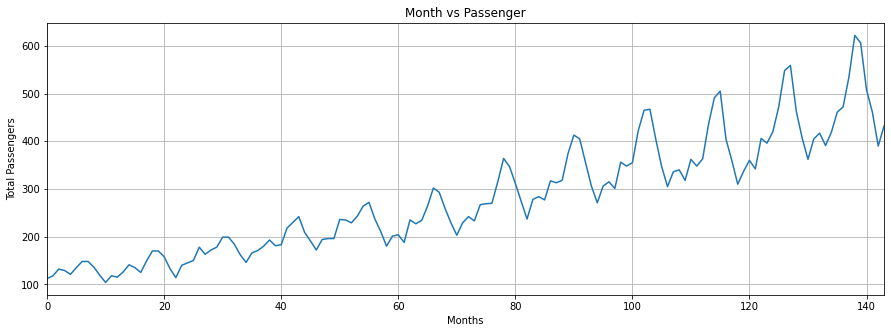

In [65]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

The output shows that over the years the average number of passengers traveling by air increased. The number of passengers traveling within a year fluctuates, which makes sense because during summer or winter vacations, the number of traveling passengers increases compared to the other parts of the year.



## Data Preprocessing

In [66]:
flight_data.columns

Index(['year', 'month', 'passengers'], dtype='object')

In [67]:
all_data = flight_data['passengers'].values.astype(float)
all_data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [68]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

132
12


In [69]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))#StandardScaler() 
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))
print(train_data_normalized.shape)

(132, 1)


It is important to mention here that data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

The next step is to convert our dataset into tensors since PyTorch models are trained using tensors. To convert the dataset into tensors, we can simply pass our dataset to the constructor of the FloatTensor object, as shown below:

In [70]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([132])

You can use any sequence length and it depends upon the domain knowledge. However, in our dataset it is convenient to use a sequence length of 12 since we have monthly data and there are 12 months in a year. If we had daily data, a better sequence length would have been 365, i.e. the number of days in a year. Therefore, we will set the input sequence length for training to 12.

In [71]:
train_window = 12

Next, we will define a function named create_inout_sequences. The function will accept the raw input data and will return a list of tuples. In each tuple, the first element will contain list of 12 items corresponding to the number of passengers traveling in 12 months, the second tuple element will contain one item i.e. the number of passengers in the 12+1st month.

In [72]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [73]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
          -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516])),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593,
          -0.9341, -1.0000, -0.9385, -0.9516]),
  tensor([-0.9033])),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341,
          -1.0000, -0.9385, -0.9516, -0.9033]), tensor([-0.8374])),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000,
          -0.9385, -0.9516, -0.9033, -0.8374]), tensor([-0.8637])),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066, -0.8593, -0.9341, -1.0000, -0.9385,
          -0.9516, -0.9033, -0.8374, -0.8637]), tensor([-0.9077]))]

In [74]:
train_inout_seq[0]

(tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
         -0.8593, -0.9341, -1.0000, -0.9385]), tensor([-0.9516]))

## Creating LSTM Model

input_size: Corresponds to the number of features in the input. Though our sequence length is 12, for each month we have only 1 value i.e. total number of passengers, therefore the input size will be 1.

hidden_layer_size: Specifies the number of hidden layers along with the number of neurons in each layer. We will have one layer of 100 neurons.

output_size: The number of items in the output, since we want to predict the number of passengers for 1 month in the future, the output size will be 1.

Inside the forward method, the input_seq is passed as a parameter, which is first passed through the lstm layer. The output of the lstm layer is the hidden and cell states at current time step, along with the output. The output from the lstm layer is passed to the linear layer. The predicted number of passengers is stored in the last item of the predictions list, which is returned to the calling function.

In [75]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

The next step is to create an object of the LSTM() class, define a loss function and the optimizer. Since, we are solving a regression problem, we will use the MSE loss. For the optimizer function, we will use the adam optimizer.

In [76]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


## Training the Model

In [77]:
epochs = 150

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.01306950
epoch:  26 loss: 0.00138737
epoch:  51 loss: 0.00173067
epoch:  76 loss: 0.00014887
epoch: 101 loss: 0.00170016
epoch: 126 loss: 0.00087942
epoch: 149 loss: 0.0014010152


In [80]:
print(seq)
print(labels)

tensor([0.0242, 0.1253, 0.0462, 0.3275, 0.2835, 0.3890, 0.6176, 0.9516, 1.0000,
        0.5780, 0.3319, 0.1341])
tensor([0.3231])


In [81]:
print(y_pred)

tensor([0.3605], grad_fn=<SelectBackward>)


## Making Predictions

In [31]:
test_inputs = train_data_normalized[-train_window:].tolist()
print(test_inputs)

[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


You can compare the above values with the last 12 values of the train_data_normalized data list.

Initially the test_inputs item will contain 12 items. Inside a for loop these 12 items will be used to make predictions about the first item from the test set i.e. the item number 133. The predict value will then be appended to the test_inputs list. During the second iteration, again the last 12 items will be used as input and a new prediction will be made which will then be appended to the test_inputs list again. The for loop will execute for 12 times since there are 12 elements in the test set. At the end of the loop the test_inputs list will contain 24 items. The last 12 items will be the predicted values for the test set.

In [32]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [41]:
len(test_inputs)

24

In [33]:
fut_pred = 12
test_inputs[fut_pred:]

[0.49459293484687805,
 0.6242454648017883,
 0.9577749967575073,
 0.7228036522865295,
 0.9619284868240356,
 0.8208774924278259,
 0.7760632634162903,
 1.0638939142227173,
 0.9418033361434937,
 1.2453750371932983,
 1.163218379020691,
 1.2103865146636963]

It is pertinent to mention again that you may get different values depending upon the weights used for training the LSTM.

Since we normalized the dataset for training, the predicted values are also normalized. We need to convert the normalized predicted values into actual predicted values. We can do so by passing the normalized values to the inverse_transform method of the min/max scaler object that we used to normalize our dataset.

In [34]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:] ).reshape(-1, 1))
print(actual_predictions)

[[444.01989268]
 [473.51584324]
 [549.39381176]
 [495.9378309 ]
 [550.33873075]
 [518.24962953]
 [508.05439243]
 [573.53586549]
 [545.76025897]
 [614.82282096]
 [596.13218123]
 [606.86293209]]


Let's now plot the predicted values against the actual values. Look at the following code:

In [35]:
x = np.arange(132, 144, 1)
print(x)

[132 133 134 135 136 137 138 139 140 141 142 143]


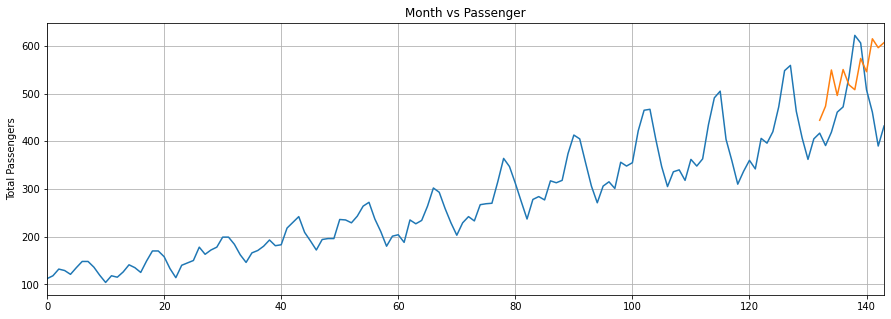

In [36]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

The predictions made by our LSTM are depicted by the orange line. You can see that our algorithm is not too accurate but still it has been able to capture upward trend for total number of passengers traveling in the last 12 months along with occasional fluctuations. You can try with a greater number of epochs and with a higher number of neurons in the LSTM layer to see if you can get better performance.

To have a better view of the output, we can plot the actual and predicted number of passengers for the last 12 months as follows:

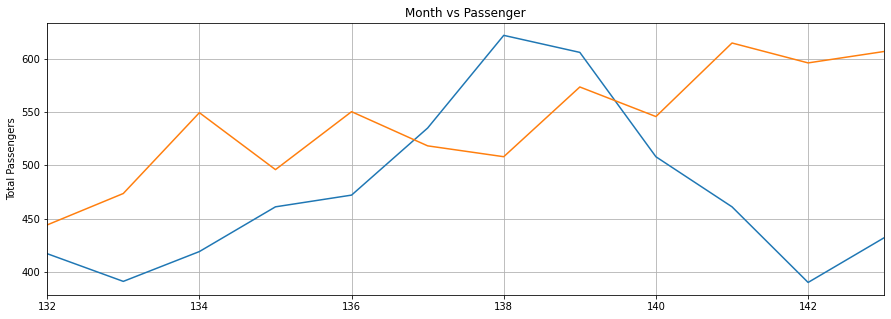

In [37]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

Conclusion

LSTM is one of the most widely used algorithm to solve sequence problems. In this article we saw how to make future predictions using time series data with LSTM. You also saw how to implement LSTM with PyTorch library and then how to plot predicted results against actual values to see how well the trained algorithm is performing.